In [1]:
import dataloader
from dataloader import clean_text, lemmatize_text
from textaug import text_aug

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder

/Users/nielspace/pytorchenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/nielspace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nielspace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nielspace/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
enc = LabelEncoder()

file_list = dataloader.csv_concat(dataloader.DATA_PATH)
df = dataloader.file_structuring(file_list)

code_enc = enc.fit_transform(df.codes)
df["code_enc"] = code_enc

df.head()

,notes,codes,desc,code_enc
0,Patient underwent surgical intervention for St...,M00.0,Staphylococcal arthritis and polyarthritis,0
1,Operative note: Patient presented with Staphyl...,M00.0,Staphylococcal arthritis and polyarthritis,0
2,Operative intervention performed for Staphylo...,M00.0,Staphylococcal arthritis and polyarthritis,0
3,Patient underwent surgical management for Stap...,M00.0,Staphylococcal arthritis and polyarthritis,0
4,Surgical intervention performed for Staphyloco...,M00.0,Staphylococcal arthritis and polyarthritis,0


In [3]:
print(df.isna().sum())

df.dropna(inplace=True)

print(df.isna().sum())

notes       9
codes       0
desc        0
code_enc    0
dtype: int64
notes       0
codes       0
desc        0
code_enc    0
dtype: int64


In [4]:
df.drop_duplicates(inplace=True)

<AxesSubplot:>

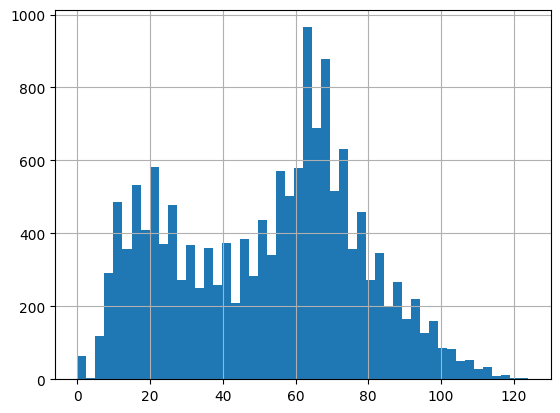

In [6]:
df['Word_Count'] = df['notes'].apply(lambda x: len(x.split()))
df.Word_Count.hist(bins=50)

In [7]:
words_to_exclude = ['Certainly!']
df = df[~df['notes'].str.contains('|'.join(words_to_exclude))].copy()

word_to_remove = ["1.", "2.", "3.", "4.", "5.", "6.", "7.", "8.", "9.", "10.", 'Certainly!', '00', '00 00', '00 00 00']
for w in word_to_remove:
    df['notes'] = df['notes'].str.replace(w, '')

df = df[df['Word_Count'] >= 10]
df.shape

(15015, 5)

In [8]:
#binarize the dataset
M45 = df[df.codes == "M45"]
M45.codes = int(0)
other = df[df.codes != "M45"]
other.codes = int(1)
other = other.sample(frac=1)
other = other[:300]

sample = pd.concat([M45, other]).sample(frac=1)
sample.head()

,notes,codes,desc,code_enc,Word_Count
152,Sacroiliitis Sacroiliac Joint Radiofrequency ...,1,"Sacroiliitis, not elsewhere classified",31,16
2786,There are surgical interventions for Pneumoco...,1,Pneumococcal arthritis and polyarthritis,1,26
224,seven. AS patient with severe bone pain in the...,0,Ankylosing spondylitis,29,38
43,Operative Note: Patient with Flatback Syndrom...,1,Flatback syndrome,18,68
88,AS patient with severe disease severity will ...,0,Ankylosing spondylitis,29,39


In [9]:
from embeddings import embeddings

# from embeddings import embeddings

(X_train, X_test, y_train, y_test, vectorizer,
feature_names, pca, labels, category_list) = embeddings.embeddings_gen(sample, "notes", "codes")

In [10]:
X_train.shape

(476, 2)

# Hyparameter Tuning

In [11]:
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

from sklearn.inspection import DecisionBoundaryDisplay


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

## Random Forest

In [11]:
rf = RandomForestClassifier(random_state=23)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: 0.9040350877192983


## Ada Boost

In [16]:
ada_boost = AdaBoostClassifier(random_state=23)

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of weak learners
    'learning_rate': [0.1, 0.5, 1.0],  # Learning rate
}


grid_search = GridSearchCV(ada_boost, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 50}
Best Score: 0.8892982456140353


## Neural Network

In [17]:
mlp = MLPClassifier(random_state=23)

param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (50, 100, 50)],  # Number of neurons in each hidden layer
    'activation': ['relu', 'tanh'],  # Activation function
    'solver': ['adam', 'sgd'],  # Solver algorithm
    'alpha': [0.0001, 0.001, 0.01],  # Regularization parameter
    'learning_rate': ['constant', 'adaptive']  # Learning rate schedule
}

grid_search = GridSearchCV(mlp, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
Best Score: 0.8892543859649124


## K-Nearest Neighbors 

In [19]:
knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': [3, 5, 7],  # Number of neighbors to consider
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  # Algorithm used to compute neighbors
}



grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 7, 'weights': 'uniform'}
Best Score: 0.8788157894736843


# Model Comparison via Decision Boundary Viz

In [12]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
]

In [13]:
classifiers = [
    KNeighborsClassifier(algorithm = 'auto', n_neighbors = 7, weights = 'uniform'),
    RandomForestClassifier(max_depth = None, min_samples_split = 5, n_estimators = 100, random_state=23),
    MLPClassifier(activation = 'relu', 
                  alpha = 0.0001, 
                  hidden_layer_sizes = (50, 100, 50), 
                  learning_rate = 'constant', 
                  solver = 'adam', random_state=23),
    AdaBoostClassifier(learning_rate = 0.1, n_estimators = 50, random_state=23),
    
    SVC(kernel="linear", C=0.025, random_state=23),
    SVC(gamma=2, C=1, random_state=23),
    DecisionTreeClassifier(max_depth=5, random_state=23),
]

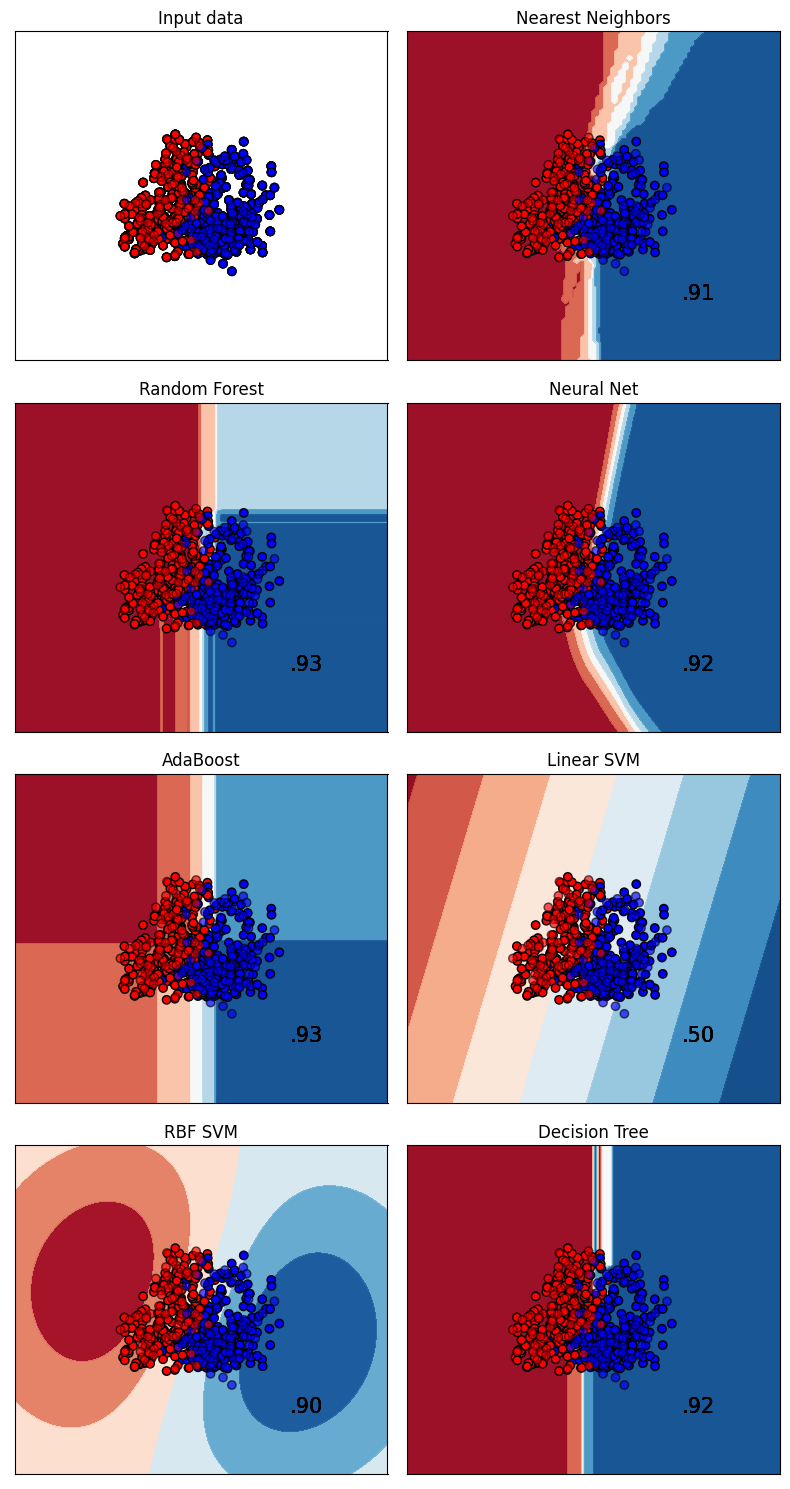

In [14]:
from viz import model_viz

model_viz.model_comp_viz(sample, "notes", "codes", model_name=names, model_architecture=classifiers)

# XGBoost

In [16]:
import xgboost as xgb

In [18]:
model = xgb.XGBClassifier()

# Define the parameter grid for grid search
param_grid = {
    'learning_rate': [0.1, 0.2, 0.3],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.9}
Best Score: 0.8907894736842106


In [19]:
XGB_clf = xgb.XGBClassifier(**best_params)
XGB_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

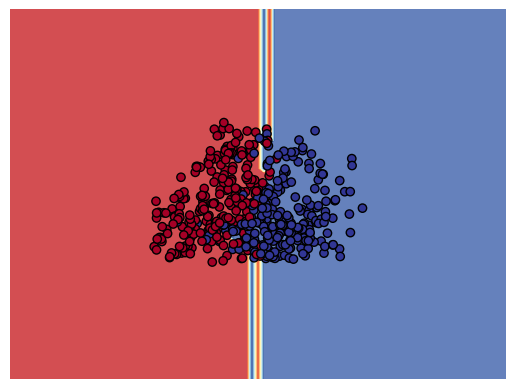

In [20]:
model_viz.plot_decision_boundary(XGB_clf, X_train, y_train)

# Results

In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_models(models, X, y):
    # Define lists to store the results
    model_names = []
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    # Iterate over the models
    for name, model in models:
        # Perform cross-validation
        scores = cross_val_score(model, X, y, cv=5)
        
        # Make predictions
        y_pred = model.fit(X, y).predict(X)
        
        # Calculate evaluation metrics
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred, average='macro')
        recall = recall_score(y, y_pred, average='macro')
        f1 = f1_score(y, y_pred, average='macro')
        
        # Append the results to the lists
        model_names.append(name)
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
    
    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Model': model_names,
        'Accuracy': accuracy_scores,
        'Precision': precision_scores,
        'Recall': recall_scores,
        'F1-Score': f1_scores
    })
    
    return results_df


In [34]:
models = [
    ('Random Forest Classifier', RandomForestClassifier(max_depth = None, 
                                                        min_samples_split = 5, 
                                                        n_estimators = 100, random_state=23)),
    ('AdaBoostClassifier', AdaBoostClassifier(learning_rate = 0.1, n_estimators = 50, random_state=23)),
    ('Neural Nets', MLPClassifier(activation = 'relu', 
                                  alpha = 0.0001, 
                                  hidden_layer_sizes = (50, 100, 50), 
                                  learning_rate = 'constant', 
                                  solver = 'adam', random_state=23)),
    ('KNN', KNeighborsClassifier(algorithm = 'auto', n_neighbors = 7, weights = 'uniform')),
    ("XGB", xgb.XGBClassifier(**best_params))
]

In [38]:
results = evaluate_models(models, X_train, y_train)
results

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest Classifier,0.989562,0.989626,0.989575,0.989561
1,AdaBoostClassifier,0.899791,0.900258,0.899756,0.899756
2,Neural Nets,0.885177,0.885333,0.885199,0.885169
3,KNN,0.910230,0.910234,0.910234,0.910230
4,XGB,0.931106,0.931117,0.931102,0.931105


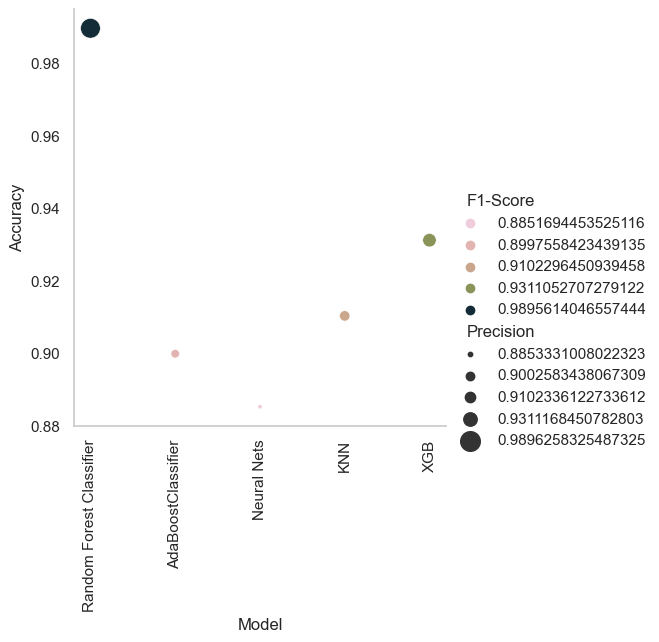

In [58]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example planets dataset
planets = sns.load_dataset("planets")

cmap = sns.cubehelix_palette(rot=-.9, as_cmap=True)

g = sns.relplot(
    data=results,
    x="Model", y="Accuracy",
    hue="F1-Score", size="Precision",
    palette=cmap, sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(False)
g.ax.yaxis.grid(False)
# g.despine(left=True, bottom=True)
plt.xticks(rotation=90)
plt.show()